Epoch 0 loss=6091.1621 NLL=6088.4790 KL=2.683066
Epoch 50 loss=5179.0044 NLL=5176.4336 KL=2.570852
Epoch 100 loss=3888.5925 NLL=3886.0840 KL=2.508698
Epoch 150 loss=3300.1836 NLL=3297.6978 KL=2.486013
Epoch 200 loss=2395.8140 NLL=2393.3037 KL=2.510398
Epoch 250 loss=2175.7317 NLL=2173.1558 KL=2.575725
Epoch 300 loss=2089.8870 NLL=2087.2400 KL=2.646932
Epoch 350 loss=1480.1044 NLL=1477.3768 KL=2.727498
Epoch 400 loss=1179.2252 NLL=1176.4169 KL=2.808312
Epoch 450 loss=1087.7932 NLL=1084.9039 KL=2.889291
Epoch 500 loss=964.8561 NLL=961.8872 KL=2.968802
Epoch 550 loss=782.7982 NLL=779.7540 KL=3.044082
Epoch 600 loss=714.9203 NLL=711.7968 KL=3.123597
Epoch 650 loss=552.3383 NLL=549.1259 KL=3.212381
Epoch 700 loss=473.0540 NLL=469.7490 KL=3.305068
Epoch 750 loss=377.7946 NLL=374.4007 KL=3.393948
Epoch 800 loss=291.0888 NLL=287.6125 KL=3.476320
Epoch 850 loss=222.7757 NLL=219.2294 KL=3.546329
Epoch 900 loss=196.5919 NLL=192.9831 KL=3.608814
Epoch 950 loss=181.2728 NLL=177.6092 KL=3.663617
Epo

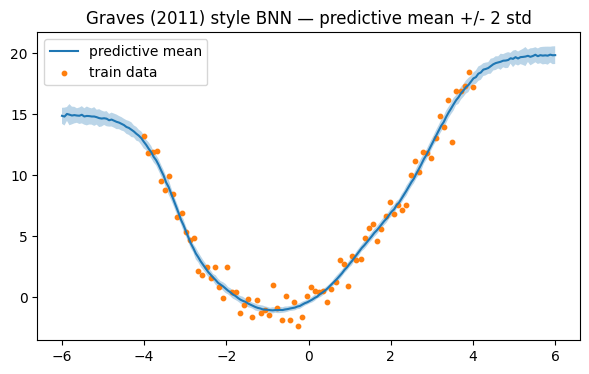

In [ ]:
# bnn_pvi_graves.py
# Practical Variational Inference (Graves 2011) — minimal working implementation in PyTorch.
# Small demo: 1D regression (y = sin(x) + noise).
# To run: python bnn_pvi_graves.py

import math
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# --- Bayesian linear layer with diagonal Gaussian q(w) = N(mu, sigma^2) ---
class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features, prior_sigma=1.0):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features

        # variational params: mu and rho (sigma = softplus(rho))
        self.w_mu = nn.Parameter(torch.randn(out_features, in_features) * 0.1)
        self.w_rho = nn.Parameter(torch.randn(out_features, in_features) * -3.0)
        self.b_mu = nn.Parameter(torch.zeros(out_features))
        self.b_rho = nn.Parameter(torch.ones(out_features) * -3.0)

        self.prior_sigma = float(prior_sigma)

    def forward(self, x, sample=True):
        # softplus
        w_sigma = F.softplus(self.w_rho)        # shape (out, in)
        b_sigma = F.softplus(self.b_rho)        # shape (out,)

        # mean activations: gamma = x @ w_mu.T
        gamma = x.matmul(self.w_mu.t())         # (batch, out)

        if sample:
            # variance of activations: delta = (x^2) @ (w_sigma^2).T
            delta = (x.pow(2)).matmul((w_sigma.pow(2)).t())   # (batch, out)
            # add bias variance for each example
            delta = delta + b_sigma.pow(2).unsqueeze(0)       # broadcast
            eps = torch.randn_like(gamma)
            out = gamma + eps * torch.sqrt(delta + 1e-8)
            # add mean bias
            out = out + self.b_mu.unsqueeze(0)
            return out
        else:
            return gamma + self.b_mu.unsqueeze(0)

    def kl_divergence(self):
        # KL(q||p) for diagonal Gaussians (p = N(0, prior_sigma^2))
        w_sigma = torch.log1p(torch.exp(self.w_rho))
        b_sigma = torch.log1p(torch.exp(self.b_rho))
        def kl_term(mu, sigma):
            var_q = sigma.pow(2)
            var_p = self.prior_sigma ** 2
            return torch.log(self.prior_sigma / sigma) + (var_q + mu.pow(2)) / (2.0 * var_p) - 0.5
        return kl_term(self.w_mu, w_sigma).sum() + kl_term(self.b_mu, b_sigma).sum()

# --- Simple Bayesian MLP (two-layer) ---
class BayesianMLP(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.l1 = BayesianLinear(in_dim, hidden_dim)
        self.l2 = BayesianLinear(hidden_dim, out_dim)
        self.act = nn.Tanh()
    def forward(self, x, sample=True):
        h = self.act(self.l1(x, sample=sample))
        return self.l2(h, sample=sample)
    def kl_divergence(self):
        return self.l1.kl_divergence() + self.l2.kl_divergence()

# --- Synthetic dataset ---
def make_data(n=30):
    x = np.linspace(-4, 4, n)[:, None].astype(np.float32)
    y = np.sin(x) + 1 * np.random.randn(*x.shape).astype(np.float32) + x**2 + x
    return torch.from_numpy(x).to(device), torch.from_numpy(y).to(device)

# --- ELBO loss: -E_q[log p(y|x,w)] + KL(q||p)
# For Gaussian likelihood with known sigma_lik (homoscedastic), log p = -0.5*log(2πσ^2) - 0.5*(y-pred)^2/σ^2
def elbo_loss(model, x, y, sigma_lik=0.1, n_samples=1, dataset_size=None):
    batch_size = x.shape[0]
    loglik_mc = torch.tensor(0., device=x.device)
    for _ in range(n_samples):
        preds = model(x, sample=True)
        ll = -0.5 * math.log(2 * math.pi * sigma_lik**2) - 0.5 * ((y - preds)**2) / (sigma_lik**2)
        loglik_mc = loglik_mc + ll.sum()
    loglik_mc = loglik_mc / n_samples  # sum over batch

    kl = model.kl_divergence()  # sum over params

    if dataset_size is None:
        # assume x is full dataset
        neg_elbo = -loglik_mc + kl
        return neg_elbo / batch_size, (-loglik_mc / batch_size).detach(), (kl / batch_size).detach()
    else:
        # scale loglik from batch to full dataset
        neg_elbo = - (dataset_size / batch_size) * loglik_mc + kl
        return neg_elbo / dataset_size, (-(dataset_size / batch_size) * loglik_mc / dataset_size).detach(), (kl / dataset_size).detach()

losses, nlls, kls = [], [], []

# --- Training demo ---
def train_demo():
    x_train, y_train = make_data(80)
    x_test = torch.linspace(-6, 6, 200)[:, None].to(device)
    model = BayesianMLP(1, 30, 1).to(device)
    optimizer = optim.Adam(model.parameters(), lr=5e-3)
    sigma_lik = 0.1

    model.train()
    for epoch in range(5000):
      optimizer.zero_grad()
      loss, nll, kl = elbo_loss(model, x_train, y_train, sigma_lik=sigma_lik, n_samples=5)
      loss.backward(); optimizer.step()

      losses.append(loss.item())
      # nll в твоём elbo_loss может быть loglik (отрицательное), так что:
      nlls.append(nll.item())  # положительный NLL
      kls.append(kl.item())

      if epoch % 50 == 0:
          print(f"Epoch {epoch} loss={loss.item():.4f} NLL={nll.item():.4f} KL={kl.item():.6f}")

    # Predictive samples to visualise uncertainty
    model.eval()
    n_samples_pred = 60
    preds = []
    with torch.no_grad():
        for _ in range(n_samples_pred):
            p = model(x_test, sample=True).cpu().numpy().squeeze()
            preds.append(p)
    preds = np.stack(preds)
    mean = preds.mean(0); std = preds.std(0); xx = x_test.cpu().numpy().squeeze()

    plt.figure(figsize=(7,4))
    plt.fill_between(xx, mean - 2*std, mean + 2*std, alpha=0.3)
    plt.plot(xx, mean, label='predictive mean')
    plt.scatter(x_train.cpu().numpy(), y_train.cpu().numpy(), s=10, label='train data')
    plt.legend(); plt.title("Graves (2011) style BNN — predictive mean +/- 2 std")
    plt.show()

if __name__ == "__main__":
    train_demo()


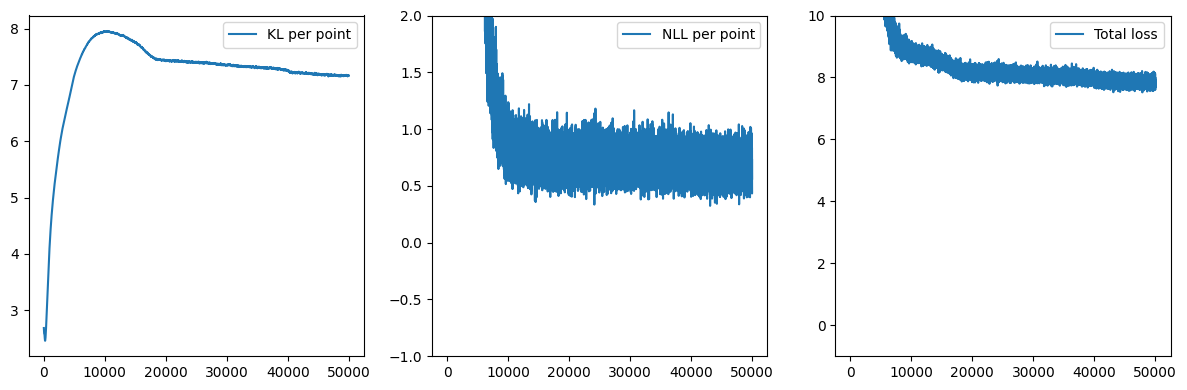

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].plot(kls, label='KL per point')
ax[0].legend()

ax[1].set_ylim(-1, 2)
ax[1].plot(nlls, label='NLL per point')
ax[1].legend()

ax[2].set_ylim(-1, 10)
ax[2].plot(losses, label='Total loss')
ax[2].legend()

plt.tight_layout()
plt.show()